In [1]:
# Данные от бюро кредитных историй получены, аггрегированы и обработаны
# Теперь приступаем к самой мякотке - будем сводить данные микрофинансовой организации "Рога и копыта" и обработанных данных
# от бюро "Заветы Ильича", чтобы построить классификатор дефолтности на основе логистической регрессии

In [2]:
# Импортируем необходиые для работы модули
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import scipy as sp
import imblearn # модуль imbalanced learning, он нужен будет для генерирования доп.выборки (см.ниже)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [3]:
# Считываем нашу и НБКИшную простыни, сводим в одну таблицу
retro_df = pd.read_excel("D:/retro_df_filtered.xlsx")
NBKI_df = pd.read_excel("D:/total_NBKI_df.xlsx")
overall_df = pd.merge(left = retro_df, right = NBKI_df, how = "left", left_on = "ID", right_on = "DataFrame_ID")

In [4]:
# Наводим косметику, передвигая зависимую бинарную переменную "Default" в конец списка колонок
cols_list = overall_df.columns.values.tolist()
cols_list = ['identifikator_fizlica', 'FIO+pass', 'ID', 'status', 'familia', 'imya', 'otchestvo',\
             'vozrast', 'vid_deyatelnosti', 'seria_pasporta', 'nomer_pasporta', 'identifikator_ankety',\
             'nomer_dogovora', 'data_platezha', 'summa_platezha', 'data_rozhdeniya', 'osn_summa', 'vozvrat',\
             'saldo', 'sost_zaima', 'stadia_dolga', 'pervich_povtor', 'ovz_nazv', 'ovz_regionRF', 'incoming',\
             'period_zaima', 'vid', 'id', 'accountRatingCount', 'amtOutstandingMean', 'amtPastDueMean',\
             'numDays30Mean', 'numDays60Mean', 'numDay90Mean', 'closed_credits', 'open_credits', 'delayed_credits',\
             'problematic_credits', 'bailiff_credits', 'bankruptcy_credits', 'pdl_total', 'pdl_closed_Incidents',\
             'pdl_open_Incidents', 'delays_pdl_Incidents', 'delays_pdl_PastDueMean', 'delays_pdl_Days30Mean',\
             'delays_pdl_Days60Mean', 'delays_pdl_Days90Mean', 'delays_pdl_OutstandingMean', 'DataFrame_ID',\
             'On_time_payment', '1_29_days_delay', '30_59_days_delay', '60_89_days_delay', '90_119_days_delay',\
             'Over_120_days_delay', 'Collateral', 'Bailiff_prosecution', 'total_PP_observation_duration',\
             'total_delay_payments_PP', 'coeff_on_time_payments', 'coeff_delays',\
             'general_delayed_credits_to_all_credits_ratio', 'pdl_delays_to_total_pdl_ration',\
             'pdl_delays_to_total_delays', 'Default']
overall_df = overall_df[cols_list]

In [5]:

overall_df.Default.value_counts()

False    6868
True     1243
Name: Default, dtype: int64

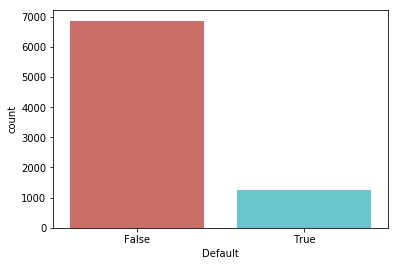

In [6]:
# Распределение дефолтности
sns.countplot(x = "Default", data = overall_df, palette="hls")

In [7]:
# Выводим пропорции биномиального распределения выборки, видим, что p ~ 0.15
count_of_default = len(overall_df[overall_df["Default"] == 1])
count_of_prompt = len(overall_df[overall_df["Default"] == 0])
pct_of_default = count_of_default/len(overall_df["Default"])
pct_of_default

0.15324867463937863

In [8]:
# Настраиваем отображение чисел с запятой из научного в обывательский формат
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
overall_df.columns.get_loc("accountRatingCount")

28

In [10]:
# Выделяем комплекс независимых переменных и зависимую переменную в отдельный фрейм, чтобы отсеить аномалии (outliers)
Union_before_trim = overall_df.iloc[:,28:]
Union_before_trim.Default = Union_before_trim.Default.astype("int")

In [11]:
# Отсеиваем аномалии в данных
import scipy as sc
Union = sc.stats.trimboth(Union_before_trim, 0.10)
Union_df = pd.DataFrame(Union, columns=Union_before_trim.columns)

In [12]:
# Выводим независимые и зависимую переменные в отдельные массивы и готовим к обработке
X = Union_df.iloc[:,:-1]
Y = pd.DataFrame(Union_df.Default.astype("int"))
Y.shape
X.shape
DataFrame_ID = X["DataFrame_ID"]
X.drop("DataFrame_ID", axis = 1,inplace=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, axis = 0, inplace=True)
Y = np.ravel(Y)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
# Наш датасет сильно скошен не в пользу дефолтных клиентов. Для балансировки выборки используем
# алгоритм SMOTE - Synthetic Minority Oversampling Technique - Техника синтетическоого генерирования доп.выборки меньшинств
# курим здесь: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_Y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_Y= pd.DataFrame(data=os_data_Y,columns=['Default'])
# Резюмируем работу алгоритма
print("Размер дополнительной выборки ",len(os_data_X))
print("Кол-во недефолтных клиентов в доп.выборке ",len(os_data_Y[os_data_Y["Default"]==0]))
print("Кол-во дефолтных клиентов в доп.выборке ",len(os_data_Y[os_data_Y["Default"]==1]))
print("Соотношение недефолтных клиентов к общему кол-ву доп.выборки ",len(os_data_Y[os_data_Y["Default"]==0])/len(os_data_X))
print("Соотношение дефолтных клиентов к общему кол-ву доп.выборки ",len(os_data_Y[os_data_Y["Default"]==1])/len(os_data_X))

Размер дополнительной выборки  8484
Кол-во недефолтных клиентов в доп.выборке  4242
Кол-во дефолтных клиентов в доп.выборке  4242
Соотношение недефолтных клиентов к общему кол-ву доп.выборки  0.5
Соотношение дефолтных клиентов к общему кол-ву доп.выборки  0.5


In [14]:
# Фильтруем независимые переменные через алгоритм рекурсивного исключения признаков - RFE
# курим здесь: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
data_final_vars=X.columns.values.tolist()
y_list=["Default"]
x_list=[i for i in data_final_vars if i not in y_list]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_Y.values.ravel())
ser1 = pd.Series(rfe.support_)
list_of_indexes = ser1[ser1 == True].index.tolist()
X = X.iloc[:,list_of_indexes]

In [15]:
# Критерий методологической триангуляции требует прогона данных через разные модели - если их результаты согласуются,
# значит, мы все делаем правильно, если сильно расходятся - что-то явно пошло не так
# Будем сравнивать две модели лог.регресии:
# 1) Logit из модуля statsmodels (не регуляризируется)
# 2) LogisticRegression из модуля sklearn (регуляризируется)

# Логит-функция для дальнейшей фильтрации массива независимых переменных
import statsmodels.api as sm
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.201111
         Iterations 9
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.178      
Dependent Variable:            y                         AIC:                       2650.0246  
Date:                          2019-03-07 10:41          BIC:                       2785.5818  
No. Observations:              6489                      Log-Likelihood:            -1305.0    
Df Model:                      19                        LL-Null:                   -1587.8    
Df Residuals:                  6469                      LLR p-value:               9.4349e-108
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                9.0000                                                          
---------------------------------------------------------------------------

In [16]:
# Исключаем те независимые переменные, для которых не подтверждается статистическая значимость (т.е. p-значение > 0.05) 
# или для которых не подтверждается релевантность (значения коэффициентов < |0.25|)
cols = ['numDays30Mean', 'numDays60Mean', 'open_credits', 'delayed_credits', 'delays_pdl_Incidents', 'coeff_on_time_payments',\
       'coeff_delays', 'pdl_delays_to_total_delays']
X = os_data_X[cols]
Y = os_data_Y["Default"]
logit_model=sm.Logit(Y, X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 7
                              Results: Logit
Model:                   Logit               Pseudo R-squared:    0.407    
Dependent Variable:      Default             AIC:                 6995.1905
Date:                    2019-03-07 10:41    BIC:                 7051.5580
No. Observations:        8484                Log-Likelihood:      -3489.6  
Df Model:                7                   LL-Null:             -5880.7  
Df Residuals:            8476                LLR p-value:         0.0000   
Converged:               1.0000              Scale:               1.0000   
No. Iterations:          7.0000                                            
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
numDays30Mean    

In [17]:
# Исключаем те независимые переменные, для которых не подтверждается статистическая значимость (т.е. p-значение > 0.05),
# не подтверждается релевантность (здравый смысл подсказывает отсутствие какой-либо причино-следственной связи между переменными)
# или которые вносят в модель мультиколлинеарность а.к.а. "ложные зависимости"
# отсекаем параметр open_credits по соображениям статистической значимости
# отсекаем параметр coeff_on_time_payments по соображениям мультиколлинеарности (ибо coeff_on_time_payments = 1  - coeff_delays)
cols = ['numDays60Mean', 'delayed_credits', 'delays_pdl_Incidents', 
       'coeff_delays', 'pdl_delays_to_total_delays']
X = X[cols]
X.describe().T

,count,mean,std,min,25%,50%,75%,max
numDays60Mean,8484.000,0.316,0.235,0.000,0.056,0.333,0.500,0.738
delayed_credits,8484.000,0.967,0.755,0.000,0.000,1.000,1.721,2.000
delays_pdl_Incidents,8484.000,0.140,0.338,0.000,0.000,0.000,0.000,1.000
coeff_delays,8484.000,0.429,0.275,0.000,0.140,0.517,0.658,0.810
pdl_delays_to_total_delays,8484.000,0.063,0.157,0.000,0.000,0.000,0.000,0.500


In [18]:
import statsmodels.api as sm
endog = Y
exog = sm.add_constant(X[X.columns.tolist()])
logit_model=sm.Logit(endog, exog)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.347945
         Iterations 7
                              Results: Logit
Model:                   Logit               Pseudo R-squared:    0.498    
Dependent Variable:      Default             AIC:                 5915.9294
Date:                    2019-03-07 10:41    BIC:                 5958.2050
No. Observations:        8484                Log-Likelihood:      -2952.0  
Df Model:                5                   LL-Null:             -5880.7  
Df Residuals:            8478                LLR p-value:         0.0000   
Converged:               1.0000              Scale:               1.0000   
No. Iterations:          7.0000                                            
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const            

In [19]:
# Отсекаем параметр pdl_delay_to_total_delays по соображениям статистической значимости
X = X.drop("pdl_delays_to_total_delays", axis = "columns")

import statsmodels.api as sm
endog = Y
exog = sm.add_constant(X[X.columns.tolist()])
logit_model=sm.Logit(endog, exog)
result=logit_model.fit()
print(result.summary2())



Optimization terminated successfully.
         Current function value: 0.347998
         Iterations 7
                           Results: Logit
Model:                 Logit             Pseudo R-squared:  0.498    
Dependent Variable:    Default           AIC:               5914.8293
Date:                  2019-03-07 10:41  BIC:               5950.0590
No. Observations:      8484              Log-Likelihood:    -2952.4  
Df Model:              4                 LL-Null:           -5880.7  
Df Residuals:          8479              LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        7.0000                                        
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -4.2099   0.1037 -40.5985 0.0000 -4.4131 -4.0067
numDays60Mean   

In [20]:
# Делим массивы даных на тренировочную и тестовую часть, тренируем модель
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# Высчитываем точность модели
Y_pred = logreg.predict(X_test)
print('Точность классификатора логистической регресии на тестовом наборе данных составляет {:.2f}'.format(logreg.score(X_test, Y_test)))
print(metrics.accuracy_score(Y_test, Y_pred))

Точность классификатора логистической регресии на тестовом наборе данных составляет 0.87
0.8719560094265515


In [22]:
# Выкатываем матрицу несоответствий
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)


[[1038  254]
 [  72 1182]]


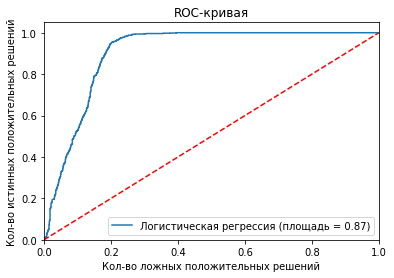

In [23]:
# Судя по матрице несоответствий, наша модель:
# Вынесла истинное положительное решение по дефолтности в 1038 случаях
# Вынесла истинное отрицательное решение по дефолтности в 1182 случаях
# Вынесла ложное положительное решение по дефолтности в 254 случаях (ошибка 1 рода)
# Вынесла ложное отрицательное решение по дефолтности в 72 случаях (ошибка 2 рода) 
# Далее рисуем ROC-кривую (соотношение правильного и ложного распознавания классов дефолтности)
# Судя по графику, модель работает значительно лучше случайного распределения (0.87 - 0.5 = 0.37, 
# т.е. на 37% точнее, синяя кривая значительно далеко остоит от красной прямой случайной классификации)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая регрессия (площадь = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Кол-во ложных положительных решений')
plt.ylabel('Кол-во истинных положительных решений')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.savefig('D:/Log_ROC.jpg')
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.94      0.80      0.86      1292
          1       0.82      0.94      0.88      1254

avg / total       0.88      0.87      0.87      2546



In [25]:
coeff_df = pd.DataFrame(list(zip(X.columns)), np.transpose(logreg.coef_))
coeff_df


,0
4.579,numDays60Mean
0.937,delayed_credits
-1.247,delays_pdl_Incidents
3.733,coeff_delays


In [26]:
logreg.intercept_

array([-4.07446601])

In [27]:
# Возвращаясь к моменту методологической триангуляции - показатели обеих моделей очень близки, значит, в самой нашей логике 
# нет критических изъянов типа непримелемо высокого уровня мультиколлинеарности, некорректной операционализации переменных и т.д.
#
#

In [28]:
# Точка пересеченния и коэффициенты в обеих моделях примерно равны 
X.describe().T

,count,mean,std,min,25%,50%,75%,max
numDays60Mean,8484.000,0.316,0.235,0.000,0.056,0.333,0.500,0.738
delayed_credits,8484.000,0.967,0.755,0.000,0.000,1.000,1.721,2.000
delays_pdl_Incidents,8484.000,0.140,0.338,0.000,0.000,0.000,0.000,1.000
coeff_delays,8484.000,0.429,0.275,0.000,0.140,0.517,0.658,0.810


In [29]:
# В конце тестим финальный массив независимых переменных на фактор инфляции дисперсии - т.е. подвержена ли модель 
# мультиколлинеарности. Приемлемым уровнем такого фактора считаем фактор до 5 включительно, т.е.
# мультиколлинеарность средней мощности, не требующей коренного пересмотра набора независимых переменных для модели
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
VIF_test = add_constant(X)
VIF_results = pd.Series([variance_inflation_factor(VIF_test.values, i) 
              for i in range(VIF_test.shape[1])], 
              index=VIF_test.columns)
VIF_filtered = VIF_results[VIF_results < 5]
VIF_filtered

const                  3.520
numDays60Mean          4.539
delayed_credits        3.660
delays_pdl_Incidents   1.340
coeff_delays           4.916
dtype: float64

In [30]:
# Все независимые переменные имеют фактор инфляции дисперсии менее 5, это подвтерждает корректность модели

In [31]:
# Выше говорили про методологическую триангуляцию. Развиваем эту идею дальше: предположим, что наши модели и вправду 
# довольно корректно описывают окружающую действительность и несут ценную информацию о статиcтически значимых зависимостях.
# В таком случае, имея на руках весовые коэффициенты каждой из независимых переменных, мы можем вывести новый параметр 
# "вероятность дефолтности" непрерывного типа со спектром значений от 0 до 1, разбить наш датасет на квартили по данному 
# параметру и посмотреть, какой процент от общего количества дефолтных клиентов находится в каждом квартиле
result.params

const                  -4.210
numDays60Mean           5.119
delayed_credits         0.873
delays_pdl_Incidents   -1.414
coeff_delays            3.757
dtype: float64

In [32]:
result.params.const

-4.209900821386826

In [33]:
# Конвертируем комплекс коэффициентов независимых переменных через логарифмы отношения шансов в вероятность дефолтности
import math
power = result.params.const +\
(Union_df["numDays60Mean"] * result.params.numDays60Mean) +\
(Union_df["delayed_credits"] * result.params.delayed_credits) +\
(Union_df["delays_pdl_Incidents"] * result.params.delays_pdl_Incidents) +\
(Union_df["coeff_delays"] * result.params.coeff_delays)
Union_df["power"] = power
e = math.e
default_prob = (e**power)/(1+(e**power))
Union_df["default_probability"] = default_prob
Union_df["DataFrame_ID"] = DataFrame_ID
s1 = set(Union_df.columns.tolist())
s2 = set(overall_df.columns.tolist())
s3 = list((s2 - s1))
joining = overall_df[s3]

In [34]:
# Для полноты картины будем вводить доп.параметры: мат.ожидание (expected value), рисковая стоимость (value-at-risk),\
# их соотношение (VaR/EV)
final_df = pd.merge(joining, Union_df , left_on = 'ID', right_on="DataFrame_ID")
final_df["Expected_value"] = (final_df.osn_summa * 1.16) - (final_df["osn_summa"]*final_df["default_probability"])
final_df["VaR"] = final_df.osn_summa*final_df.default_probability
final_df["VaR/EV"] = final_df.VaR / final_df.Expected_value
final_df.to_excel("D:/fin_df.xlsx")

In [52]:
# Разбиваем массив данных на квартили по новому параметру "default_probability"
crit_4_quartile = final_df.default_probability < 0.25
crit_3_quartile = (final_df.default_probability >= 0.25) & (final_df.default_probability < 0.5)
crit_2_quartile = (final_df.default_probability >= 0.5) & (final_df.default_probability < 0.75)
crit_1_quartile = final_df.default_probability > 0.75
testing_predictor_4_quartile = final_df[crit_4_quartile]
testing_predictor_3_quartile = final_df[crit_3_quartile]
testing_predictor_2_quartile = final_df[crit_2_quartile]
testing_predictor_1_quartile = final_df[crit_1_quartile]

In [56]:
# Резюмируем точность нашего нового параметры "вероятность дефолта" - ч.1
print("В 4 квартиле по вероятности дефолта находится ",round(len(testing_predictor_4_quartile)/len(final_df)*100, 2), "всего датасета")
print("В 3 квартиле по вероятности дефолта находится ",round(len(testing_predictor_3_quartile)/len(final_df)*100, 2), "всего датасета")
print("Во 2 квартиле по вероятности дефолта находится ",round(len(testing_predictor_2_quartile)/len(final_df)*100, 2), "всего датасета")
print("В 1 квартиле по вероятности дефолта находится ",round(len(testing_predictor_1_quartile)/len(final_df)*100, 2), "всего датасета")


В 4 квартиле по вероятности дефолта находится  71.65 всего датасета
В 3 квартиле по вероятности дефолта находится  4.54 всего датасета
Во 2 квартиле по вероятности дефолта находится  7.95 всего датасета
В 1 квартиле по вероятности дефолта находится  15.85 всего датасета


In [57]:
# Резюмируем точность нашего нового параметры "вероятность дефолта" - ч.2
print("В 4 квартиле по вероятности дефолта находится ", round(testing_predictor_4_quartile.Default.sum()/final_df.Default.sum()*100,2), "всех дефолтных клиентов")
print("В 3 квартиле по вероятности дефолта находится ", round(testing_predictor_3_quartile.Default.sum()/final_df.Default.sum()*100,2), "всех дефолтных клиентов")
print("Во 2 квартиле по вероятности дефолта находится ", round(testing_predictor_2_quartile.Default.sum()/final_df.Default.sum()*100,2), "всех дефолтных клиентов")
print("В 1 квартиле по вероятности дефолта находится ", round(testing_predictor_1_quartile.Default.sum()/final_df.Default.sum()*100,2), "всех дефолтных клиентов")

В 4 квартиле по вероятности дефолта находится  2.71 всех дефолтных клиентов
В 3 квартиле по вероятности дефолта находится  8.71 всех дефолтных клиентов
Во 2 квартиле по вероятности дефолта находится  23.3 всех дефолтных клиентов
В 1 квартиле по вероятности дефолта находится  65.27 всех дефолтных клиентов
